In [71]:
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import numpy as np

import matplotlib.pyplot as plt

In [235]:
# Read Data
data = pd.read_csv('Data/requiredMunicipalities_temperature_precipitation_elevation_DengueCasesWeek.csv')
# Remove extra column
data = data.drop('Unnamed: 0', 1)

In [236]:
data.head()

,State,Municipality,PRECIPITATION_jan_07,PRECIPITATION_feb_07,PRECIPITATION_mar_07,PRECIPITATION_apr_07,PRECIPITATION_may_07,PRECIPITATION_jun_07,PRECIPITATION_jul_07,PRECIPITATION_aug_07,PRECIPITATION_sep_07,PRECIPITATION_oct_07,PRECIPITATION_nov_07,PRECIPITATION_dec_07,PRECIPITATION_jan_08,PRECIPITATION_feb_08,PRECIPITATION_mar_08,PRECIPITATION_apr_08,PRECIPITATION_may_08,PRECIPITATION_jun_08,PRECIPITATION_jul_08,PRECIPITATION_aug_08,PRECIPITATION_sep_08,PRECIPITATION_oct_08,PRECIPITATION_nov_08,PRECIPITATION_dec_08,PRECIPITATION_jan_09,PRECIPITATION_feb_09,PRECIPITATION_mar_09,PRECIPITATION_apr_09,PRECIPITATION_may_09,PRECIPITATION_jun_09,PRECIPITATION_jul_09,PRECIPITATION_aug_09,PRECIPITATION_sep_09,PRECIPITATION_oct_09,PRECIPITATION_nov_09,PRECIPITATION_dec_09,PRECIPITATION_jan_10,PRECIPITATION_feb_10,...,2019/w13,2019/w14,2019/w15,2019/w16,2019/w17,2019/w18,2019/w19,2019/w20,2019/w21,2019/w22,2019/w23,2019/w24,2019/w25,2019/w26,2019/w27,2019/w28,2019/w29,2019/w30,2019/w31,2019/w32,2019/w33,2019/w34,2019/w35,2019/w36,2019/w37,2019/w38,2019/w39,2019/w40,2019/w41,2019/w42,2019/w43,2019/w44,2019/w45,2019/w46,2019/w47,2019/w48,2019/w49,2019/w50,2019/w51,2019/w52
0,antioquia,alejandria,66.638855,66.628891,199.928375,286.881470,345.874695,161.073792,339.436737,324.082489,243.856186,361.769562,285.962006,171.435532,91.634064,140.104874,141.978943,252.502441,922.231750,236.358551,399.940521,425.720917,235.005325,367.640900,320.049988,218.923187,147.733185,165.971741,250.059143,199.013580,310.712250,218.631714,169.890945,317.373627,223.847336,349.601868,208.563354,114.181557,23.847799,82.361053,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,antioquia,amaga,62.527489,46.315376,166.522003,288.957397,350.666260,143.757507,350.168793,210.302658,214.617142,283.321747,279.687347,198.276825,82.823952,139.362946,122.149208,246.294891,1056.371826,233.371964,343.933350,306.676270,213.928513,248.733658,302.210754,232.676270,126.071480,128.074234,205.597870,165.801498,234.811264,206.055435,127.413780,236.348267,192.895981,290.498383,194.566284,140.502640,14.430646,75.684792,...,0,0,0,0,0,1,2,3,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
2,antioquia,amalfi,76.737572,62.784908,198.478897,322.928314,381.405701,191.377609,387.475983,408.289520,306.408356,385.371216,336.976227,175.587463,98.434227,97.761215,183.319458,269.138306,851.275208,241.106689,458.701965,496.593597,265.008057,411.743866,385.076141,232.894592,154.217178,130.631485,256.707947,247.239822,362.843414,241.188202,230.991714,357.351288,269.511658,352.920532,263.026733,123.605858,47.158634,60.811092,...,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,antioquia,andes,115.193504,61.572941,205.126846,308.268433,332.884583,116.664536,310.750671,189.581451,194.997574,333.450806,295.312958,256.798615,151.755310,209.275269,157.795776,267.709290,1036.946411,197.896515,295.078308,279.076172,196.854523,268.346375,321.546906,290.615112,221.921097,174.336456,255.471024,165.742081,205.896408,170.882233,101.799400,211.234085,172.778656,333.647278,199.595963,186.578568,19.903400,109.078812,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,antioquia,angelopolis,69.933151,43.129227,178.370377,278.665588,326.885010,144.349655,360.914429,234.040939,214.994553,291.776550,281.021088,189.771225,91.823616,128.047577,130.140381,235.732956,995.114075,233.658310,351.166199,344.687408,211.449844,260.028564,300.990601,224.315628,140.098541,117.915977,219.942856,160.306305,218.278122,207.616272,129.507202,265.811707,193.182587,302.892700,195.555344,134.629974,17.000061,69.415474,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Columns with temperature, precipitation, and Dengue Cases

In [237]:
# Take just temperature data
x_temperature = data[data.columns[147:291]]
x_temperature.head()

,TEMPERATURE_jan_07,TEMPERATURE_feb_07,TEMPERATURE_mar_07,TEMPERATURE_apr_07,TEMPERATURE_may_07,TEMPERATURE_jun_07,TEMPERATURE_jul_07,TEMPERATURE_aug_07,TEMPERATURE_sep_07,TEMPERATURE_oct_07,TEMPERATURE_nov_07,TEMPERATURE_dec_07,TEMPERATURE_jan_08,TEMPERATURE_feb_08,TEMPERATURE_mar_08,TEMPERATURE_apr_08,TEMPERATURE_may_08,TEMPERATURE_jun_08,TEMPERATURE_jul_08,TEMPERATURE_aug_08,TEMPERATURE_sep_08,TEMPERATURE_oct_08,TEMPERATURE_nov_08,TEMPERATURE_dec_08,TEMPERATURE_jan_09,TEMPERATURE_feb_09,TEMPERATURE_mar_09,TEMPERATURE_apr_09,TEMPERATURE_may_09,TEMPERATURE_jun_09,TEMPERATURE_jul_09,TEMPERATURE_aug_09,TEMPERATURE_sep_09,TEMPERATURE_oct_09,TEMPERATURE_nov_09,TEMPERATURE_dec_09,TEMPERATURE_jan_10,TEMPERATURE_feb_10,TEMPERATURE_mar_10,TEMPERATURE_apr_10,...,TEMPERATURE_sep_15,TEMPERATURE_oct_15,TEMPERATURE_nov_15,TEMPERATURE_dec_15,TEMPERATURE_jan_16,TEMPERATURE_feb_16,TEMPERATURE_mar_16,TEMPERATURE_apr_16,TEMPERATURE_may_16,TEMPERATURE_jun_16,TEMPERATURE_jul_16,TEMPERATURE_aug_16,TEMPERATURE_sep_16,TEMPERATURE_oct_16,TEMPERATURE_nov_16,TEMPERATURE_dec_16,TEMPERATURE_jan_17,TEMPERATURE_feb_17,TEMPERATURE_mar_17,TEMPERATURE_apr_17,TEMPERATURE_may_17,TEMPERATURE_jun_17,TEMPERATURE_jul_17,TEMPERATURE_aug_17,TEMPERATURE_sep_17,TEMPERATURE_oct_17,TEMPERATURE_nov_17,TEMPERATURE_dec_17,TEMPERATURE_jan_18,TEMPERATURE_feb_18,TEMPERATURE_mar_18,TEMPERATURE_apr_18,TEMPERATURE_may_18,TEMPERATURE_jun_18,TEMPERATURE_jul_18,TEMPERATURE_aug_18,TEMPERATURE_sep_18,TEMPERATURE_oct_18,TEMPERATURE_nov_18,TEMPERATURE_dec_18
0,20.606707,20.672624,21.210392,21.113854,21.331241,21.114738,21.333450,20.634999,20.499266,19.855212,20.018971,19.881327,20.107835,20.358041,20.713429,21.015158,20.705113,20.802585,20.796298,20.581962,20.694927,19.958251,19.779387,19.572386,20.102366,20.214117,20.041468,21.004741,21.138620,21.067168,21.312791,21.638038,21.722964,21.078910,21.115932,21.366743,21.531707,21.776617,22.899976,21.884080,...,22.043798,21.431949,21.015933,21.747211,22.035873,22.390246,21.706051,22.384080,22.221606,22.105623,21.924335,22.346545,21.615760,21.264327,20.604387,20.678288,20.418252,20.966983,20.989558,21.796407,21.574037,21.342168,21.841958,20.969809,21.722964,20.936289,20.707426,20.480198,20.606707,20.862208,21.489558,20.985991,21.025772,21.377411,21.652374,21.425886,21.230342,20.725872,20.687894,20.574121
1,20.814870,20.851651,21.328261,21.144019,21.174519,20.900712,21.281823,20.447760,20.407709,19.706597,19.881884,19.933408,20.301328,20.503733,20.764200,20.907040,20.594570,20.621024,20.658124,20.467551,20.453541,19.829513,19.751676,19.713877,20.314869,20.309984,20.135293,20.976572,20.998216,20.884566,21.298489,21.563906,21.517864,20.825346,21.028499,21.400334,21.741953,21.786807,23.000918,22.004436,...,21.783229,21.329513,20.931364,21.872991,22.110703,22.463369,21.939199,22.347405,22.057070,21.804097,21.787292,22.174323,21.303802,21.022482,20.484749,20.706845,20.525287,21.036807,21.055085,21.771884,21.404466,21.121024,21.760989,20.817552,21.520729,20.829513,20.635009,20.580022,20.688046,20.980035,21.648314,21.020582,20.880769,21.149931,21.560988,21.380573,21.026458,20.558420,20.625113,20.717262
2,21.520126,21.536331,22.240293,22.223073,22.306279,22.010652,22.411260,21.424171,21.347958,20.695219,20.888090,20.842101,20.980630,21.211158,21.652705,22.070816,21.622859,21.718899,21.888344,21.426429,21.504380,20.797476,20.733924,20.622917,21.055803,21.123918,21.113209,22.056146,22.108190,22.018898,22.455184,22.472261,22.491968,21.874559,21.973420,22.260592,22.405456,22.569839,23.879789,22.968560,...,22.781116,22.251642,21.861008,22.658334,22.834796,23.209248,22.640292,23.456146,23.145776,23.000148,23.009350,23.124171,22.400214,22.072302,21.461006,21.583508,21.307714,21.790498,21.940292,22.970817,22.518693,22.277231,22.882267,21.871915,22.491968,21.772303,21.565174,21.471095,21.507713,21.721662,22.440292,22.133230,21.910445,22.177232,22.709351,22.234674,22.014884,21.497476,21.550504,21.471094
3,17.030849,16.976915,17.263741,17.063804,17.199818,17.03

In [238]:
# Take just precipitation data
x_precipitation = data[data.columns[2:146]]
x_precipitation.head()

,PRECIPITATION_jan_07,PRECIPITATION_feb_07,PRECIPITATION_mar_07,PRECIPITATION_apr_07,PRECIPITATION_may_07,PRECIPITATION_jun_07,PRECIPITATION_jul_07,PRECIPITATION_aug_07,PRECIPITATION_sep_07,PRECIPITATION_oct_07,PRECIPITATION_nov_07,PRECIPITATION_dec_07,PRECIPITATION_jan_08,PRECIPITATION_feb_08,PRECIPITATION_mar_08,PRECIPITATION_apr_08,PRECIPITATION_may_08,PRECIPITATION_jun_08,PRECIPITATION_jul_08,PRECIPITATION_aug_08,PRECIPITATION_sep_08,PRECIPITATION_oct_08,PRECIPITATION_nov_08,PRECIPITATION_dec_08,PRECIPITATION_jan_09,PRECIPITATION_feb_09,PRECIPITATION_mar_09,PRECIPITATION_apr_09,PRECIPITATION_may_09,PRECIPITATION_jun_09,PRECIPITATION_jul_09,PRECIPITATION_aug_09,PRECIPITATION_sep_09,PRECIPITATION_oct_09,PRECIPITATION_nov_09,PRECIPITATION_dec_09,PRECIPITATION_jan_10,PRECIPITATION_feb_10,PRECIPITATION_mar_10,PRECIPITATION_apr_10,...,PRECIPITATION_sep_15,PRECIPITATION_oct_15,PRECIPITATION_nov_15,PRECIPITATION_dec_15,PRECIPITATION_jan_16,PRECIPITATION_feb_16,PRECIPITATION_mar_16,PRECIPITATION_apr_16,PRECIPITATION_may_16,PRECIPITATION_jun_16,PRECIPITATION_jul_16,PRECIPITATION_aug_16,PRECIPITATION_sep_16,PRECIPITATION_oct_16,PRECIPITATION_nov_16,PRECIPITATION_dec_16,PRECIPITATION_jan_17,PRECIPITATION_feb_17,PRECIPITATION_mar_17,PRECIPITATION_apr_17,PRECIPITATION_may_17,PRECIPITATION_jun_17,PRECIPITATION_jul_17,PRECIPITATION_aug_17,PRECIPITATION_sep_17,PRECIPITATION_oct_17,PRECIPITATION_nov_17,PRECIPITATION_dec_17,PRECIPITATION_jan_18,PRECIPITATION_feb_18,PRECIPITATION_mar_18,PRECIPITATION_apr_18,PRECIPITATION_may_18,PRECIPITATION_jun_18,PRECIPITATION_jul_18,PRECIPITATION_aug_18,PRECIPITATION_sep_18,PRECIPITATION_oct_18,PRECIPITATION_nov_18,PRECIPITATION_dec_18
0,66.638855,66.628891,199.928375,286.881470,345.874695,161.073792,339.436737,324.082489,243.856186,361.769562,285.962006,171.435532,91.634064,140.104874,141.978943,252.502441,922.231750,236.358551,399.940521,425.720917,235.005325,367.640900,320.049988,218.923187,147.733185,165.971741,250.059143,199.013580,310.712250,218.631714,169.890945,317.373627,223.847336,349.601868,208.563354,114.181557,23.847799,82.361053,140.205505,343.347748,...,181.159897,217.798950,199.683243,50.143784,74.901917,56.408119,123.612137,273.012634,231.279205,115.304100,193.332321,298.988617,267.838226,266.072052,145.723358,138.651657,107.291565,136.565781,105.653427,238.820831,199.921234,181.151321,115.703644,395.903473,244.643143,321.093597,252.829453,137.453506,140.216995,86.449814,147.506775,292.958588,436.878143,225.225449,195.619019,256.421906,302.413086,353.701385,277.470184,61.464046
1,62.527489,46.315376,166.522003,288.957397,350.666260,143.757507,350.168793,210.302658,214.617142,283.321747,279.687347,198.276825,82.823952,139.362946,122.149208,246.294891,1056.371826,233.371964,343.933350,306.676270,213.928513,248.733658,302.210754,232.676270,126.071480,128.074234,205.597870,165.801498,234.811264,206.055435,127.413780,236.348267,192.895981,290.498383,194.566284,140.502640,14.430646,75.684792,126.910789,332.311279,...,162.664734,184.293777,188.470245,52.162560,64.502235,46.120049,112.637077,241.846619,239.185791,107.121597,155.130295,213.129028,251.061081,219.268570,129.375320,158.177811,85.948349,112.548958,100.372108,211.559204,194.846909,174.252808,94.737900,293.564240,222.163391,281.282043,253.455612,165.416397,123.736755,91.315475,117.747261,256.695129,421.436859,195.391815,162.015167,182.192062,274.654327,259.078125,282.538574,68.923813
2,76.737572,62.784908,198.478897,322.928314,381.405701,191.377609,387.475983,408.289520,306.408356,385.371216,336.976227,175.587463,98.434227,97.761215,183.319458,269.138306,851.275208,241.106689,458.701965,496.593597,265.008057,411.743866,385.076141,232.894592,154.217178,130.631485,256.707947,247.239822,362.843414,241.188202,230.991714,357.351288,269.511658,352.920532,263.026733,123.605858,47.158634,60.811092,141.417007,354.992554,...,203.632858,199.490601,226.388794,53.587704,66.496948,44.471161,116.046555,301.919067,234.341919,128.027725,252.298584,334.90

In [239]:
# Take Columns of weekly cases (week 1 2007 - week 52 2018)
y_data = data[data.columns[343:-52]]
y_data.head()

,2007/w01,2007/w02,2007/w03,2007/w04,2007/w05,2007/w06,2007/w07,2007/w08,2007/w09,2007/w10,2007/w11,2007/w12,2007/w13,2007/w14,2007/w15,2007/w16,2007/w17,2007/w18,2007/w19,2007/w20,2007/w21,2007/w22,2007/w23,2007/w24,2007/w25,2007/w26,2007/w27,2007/w28,2007/w29,2007/w30,2007/w31,2007/w32,2007/w33,2007/w34,2007/w35,2007/w36,2007/w37,2007/w38,2007/w39,2007/w40,...,2018/w13,2018/w14,2018/w15,2018/w16,2018/w17,2018/w18,2018/w19,2018/w20,2018/w21,2018/w22,2018/w23,2018/w24,2018/w25,2018/w26,2018/w27,2018/w28,2018/w29,2018/w30,2018/w31,2018/w32,2018/w33,2018/w34,2018/w35,2018/w36,2018/w37,2018/w38,2018/w39,2018/w40,2018/w41,2018/w42,2018/w43,2018/w44,2018/w45,2018/w46,2018/w47,2018/w48,2018/w49,2018/w50,2018/w51,2018/w52
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Data Pre-processing

# Temperature, Percipitation and Dengue Cases weekly 2007-2018 for Medellin

Temperature, Percipitation, Cases for Medellin from original data  (sivigila - cases) (google earth engine - precipitation and worldclim - temperature)

In [240]:
# Take just the row of Medellin from original dataframe
data_medellin = data[data.Municipality=='medellin']
data_medellin

,State,Municipality,PRECIPITATION_jan_07,PRECIPITATION_feb_07,PRECIPITATION_mar_07,PRECIPITATION_apr_07,PRECIPITATION_may_07,PRECIPITATION_jun_07,PRECIPITATION_jul_07,PRECIPITATION_aug_07,PRECIPITATION_sep_07,PRECIPITATION_oct_07,PRECIPITATION_nov_07,PRECIPITATION_dec_07,PRECIPITATION_jan_08,PRECIPITATION_feb_08,PRECIPITATION_mar_08,PRECIPITATION_apr_08,PRECIPITATION_may_08,PRECIPITATION_jun_08,PRECIPITATION_jul_08,PRECIPITATION_aug_08,PRECIPITATION_sep_08,PRECIPITATION_oct_08,PRECIPITATION_nov_08,PRECIPITATION_dec_08,PRECIPITATION_jan_09,PRECIPITATION_feb_09,PRECIPITATION_mar_09,PRECIPITATION_apr_09,PRECIPITATION_may_09,PRECIPITATION_jun_09,PRECIPITATION_jul_09,PRECIPITATION_aug_09,PRECIPITATION_sep_09,PRECIPITATION_oct_09,PRECIPITATION_nov_09,PRECIPITATION_dec_09,PRECIPITATION_jan_10,PRECIPITATION_feb_10,...,2019/w13,2019/w14,2019/w15,2019/w16,2019/w17,2019/w18,2019/w19,2019/w20,2019/w21,2019/w22,2019/w23,2019/w24,2019/w25,2019/w26,2019/w27,2019/w28,2019/w29,2019/w30,2019/w31,2019/w32,2019/w33,2019/w34,2019/w35,2019/w36,2019/w37,2019/w38,2019/w39,2019/w40,2019/w41,2019/w42,2019/w43,2019/w44,2019/w45,2019/w46,2019/w47,2019/w48,2019/w49,2019/w50,2019/w51,2019/w52
62,antioquia,medellin,65.4114,49.307404,195.452469,291.927124,345.532501,157.963028,386.515533,230.007416,234.679382,320.92984,275.321289,184.041061,86.091049,131.370422,140.433243,246.781662,1033.192017,248.036789,390.182495,332.141724,226.306137,302.420685,295.516663,223.920044,133.955582,130.186417,241.387421,177.008194,250.477356,224.566727,148.674896,255.542786,211.922562,331.874115,194.040817,128.476959,18.438709,72.643066,...,21,18,11,18,28,22,16,26,27,24,32,25,25,23,39,28,37,23,25,36,34,40,43,28,30,49,45,35,29,26,29,17,35,16,21,15,20,30,14,5


### PRECIPITATION DATA

In [241]:
# Take the columns of precipitation for Medellin
x_precipitation_medellin = data_medellin[data_medellin.columns[2:146]]
x_precipitation_medellin

,PRECIPITATION_jan_07,PRECIPITATION_feb_07,PRECIPITATION_mar_07,PRECIPITATION_apr_07,PRECIPITATION_may_07,PRECIPITATION_jun_07,PRECIPITATION_jul_07,PRECIPITATION_aug_07,PRECIPITATION_sep_07,PRECIPITATION_oct_07,PRECIPITATION_nov_07,PRECIPITATION_dec_07,PRECIPITATION_jan_08,PRECIPITATION_feb_08,PRECIPITATION_mar_08,PRECIPITATION_apr_08,PRECIPITATION_may_08,PRECIPITATION_jun_08,PRECIPITATION_jul_08,PRECIPITATION_aug_08,PRECIPITATION_sep_08,PRECIPITATION_oct_08,PRECIPITATION_nov_08,PRECIPITATION_dec_08,PRECIPITATION_jan_09,PRECIPITATION_feb_09,PRECIPITATION_mar_09,PRECIPITATION_apr_09,PRECIPITATION_may_09,PRECIPITATION_jun_09,PRECIPITATION_jul_09,PRECIPITATION_aug_09,PRECIPITATION_sep_09,PRECIPITATION_oct_09,PRECIPITATION_nov_09,PRECIPITATION_dec_09,PRECIPITATION_jan_10,PRECIPITATION_feb_10,PRECIPITATION_mar_10,PRECIPITATION_apr_10,...,PRECIPITATION_sep_15,PRECIPITATION_oct_15,PRECIPITATION_nov_15,PRECIPITATION_dec_15,PRECIPITATION_jan_16,PRECIPITATION_feb_16,PRECIPITATION_mar_16,PRECIPITATION_apr_16,PRECIPITATION_may_16,PRECIPITATION_jun_16,PRECIPITATION_jul_16,PRECIPITATION_aug_16,PRECIPITATION_sep_16,PRECIPITATION_oct_16,PRECIPITATION_nov_16,PRECIPITATION_dec_16,PRECIPITATION_jan_17,PRECIPITATION_feb_17,PRECIPITATION_mar_17,PRECIPITATION_apr_17,PRECIPITATION_may_17,PRECIPITATION_jun_17,PRECIPITATION_jul_17,PRECIPITATION_aug_17,PRECIPITATION_sep_17,PRECIPITATION_oct_17,PRECIPITATION_nov_17,PRECIPITATION_dec_17,PRECIPITATION_jan_18,PRECIPITATION_feb_18,PRECIPITATION_mar_18,PRECIPITATION_apr_18,PRECIPITATION_may_18,PRECIPITATION_jun_18,PRECIPITATION_jul_18,PRECIPITATION_aug_18,PRECIPITATION_sep_18,PRECIPITATION_oct_18,PRECIPITATION_nov_18,PRECIPITATION_dec_18
62,65.4114,49.307404,195.452469,291.927124,345.532501,157.963028,386.515533,230.007416,234.679382,320.92984,275.321289,184.041061,86.091049,131.370422,140.433243,246.781662,1033.192017,248.036789,390.182495,332.141724,226.306137,302.420685,295.516663,223.920044,133.955582,130.186417,241.387421,177.008194,250.477356,224.566727,148.674896,255.542786,211.922562,331.874115,194.040817,128.476959,18.438709,72.643066,146.273071,337.406647,...,179.241959,213.469482,184.867233,49.636089,67.450592,46.293457,126.497833,249.590607,233.860794,118.415253,177.197144,235.356659,266.614624,252.005188,127.503548,149.539246,93.142609,111.025299,113.966263,218.512985,192.741974,185.905487,109.116791,323.284515,248.888855,318.701874,245.842239,152.662018,131.176727,86.131554,140.323318,267.799438,418.379303,219.436752,180.841248,200.803131,294.888611,302.151306,276.914551,67.528


In [242]:
# Transpose the row to a Column of precipitation for Medellin
x_precipitation_medellin_transposed = x_precipitation_medellin.T
x_precipitation_medellin_transposed = x_precipitation_medellin_transposed.rename(columns= {62:'percipitation_medellin'})  ##integer
x_precipitation_medellin_transposed

,percipitation_medellin
PRECIPITATION_jan_07,65.411400
PRECIPITATION_feb_07,49.307404
PRECIPITATION_mar_07,195.452469
PRECIPITATION_apr_07,291.927124
PRECIPITATION_may_07,345.532501
...,...
PRECIPITATION_aug_18,200.803131
PRECIPITATION_sep_18,294.888611
PRECIPITATION_oct_18,302.151306
PRECIPITATION_nov_18,276.914551


## Get date of precipitation from index 

In [243]:
#Create a new column of date
x_precipitation_medellin_transposed['DATE']=x_precipitation_medellin_transposed.index.str.split("_")
x_precipitation_medellin_transposed

,percipitation_medellin,DATE
PRECIPITATION_jan_07,65.411400,"[PRECIPITATION, jan, 07]"
PRECIPITATION_feb_07,49.307404,"[PRECIPITATION, feb, 07]"
PRECIPITATION_mar_07,195.452469,"[PRECIPITATION, mar, 07]"
PRECIPITATION_apr_07,291.927124,"[PRECIPITATION, apr, 07]"
PRECIPITATION_may_07,345.532501,"[PRECIPITATION, may, 07]"
...,...,...
PRECIPITATION_aug_18,200.803131,"[PRECIPITATION, aug, 18]"
PRECIPITATION_sep_18,294.888611,"[PRECIPITATION, sep, 18]"
PRECIPITATION_oct_18,302.151306,"[PRECIPITATION, oct, 18]"
PRECIPITATION_nov_18,276.914551,"[PRECIPITATION, nov, 18]"


In [244]:
#get year from date column
x_precipitation_medellin_transposed['YEAR'] = x_precipitation_medellin_transposed['DATE'].apply(lambda x: "20" + x[2])  
x_precipitation_medellin_transposed.head()

,percipitation_medellin,DATE,YEAR
PRECIPITATION_jan_07,65.411400,"[PRECIPITATION, jan, 07]",2007
PRECIPITATION_feb_07,49.307404,"[PRECIPITATION, feb, 07]",2007
PRECIPITATION_mar_07,195.452469,"[PRECIPITATION, mar, 07]",2007
PRECIPITATION_apr_07,291.927124,"[PRECIPITATION, apr, 07]",2007
PRECIPITATION_may_07,345.532501,"[PRECIPITATION, may, 07]",2007


In [245]:
#get year from date column
x_precipitation_medellin_transposed['MONTH'] = x_precipitation_medellin_transposed['DATE'].apply(lambda x: x[1])  
x_precipitation_medellin_transposed.head()

,percipitation_medellin,DATE,YEAR,MONTH
PRECIPITATION_jan_07,65.411400,"[PRECIPITATION, jan, 07]",2007,jan
PRECIPITATION_feb_07,49.307404,"[PRECIPITATION, feb, 07]",2007,feb
PRECIPITATION_mar_07,195.452469,"[PRECIPITATION, mar, 07]",2007,mar
PRECIPITATION_apr_07,291.927124,"[PRECIPITATION, apr, 07]",2007,apr
PRECIPITATION_may_07,345.532501,"[PRECIPITATION, may, 07]",2007,may


In [246]:
## function to change month as int to numeric
def month_as_int(month):
  if month == 'jan':
    return '01'
  if month == 'feb':
    return '02' 
  if month == 'mar':
    return '03'
  if month == 'apr':
    return '04' 
  if month == 'may':
    return '05'
  if month == 'jun':
    return '06' 
  if month == 'jul':
    return '07'
  if month == 'aug':
    return '08' 
  if month == 'sep':
    return '09'
  if month == 'oct':
    return '10' 
  if month == 'nov':
    return '11'   
  if month == 'dec':
    return '12'


In [247]:
x_precipitation_medellin_transposed

,percipitation_medellin,DATE,YEAR,MONTH
PRECIPITATION_jan_07,65.411400,"[PRECIPITATION, jan, 07]",2007,jan
PRECIPITATION_feb_07,49.307404,"[PRECIPITATION, feb, 07]",2007,feb
PRECIPITATION_mar_07,195.452469,"[PRECIPITATION, mar, 07]",2007,mar
PRECIPITATION_apr_07,291.927124,"[PRECIPITATION, apr, 07]",2007,apr
PRECIPITATION_may_07,345.532501,"[PRECIPITATION, may, 07]",2007,may
...,...,...,...,...
PRECIPITATION_aug_18,200.803131,"[PRECIPITATION, aug, 18]",2018,aug
PRECIPITATION_sep_18,294.888611,"[PRECIPITATION, sep, 18]",2018,sep
PRECIPITATION_oct_18,302.151306,"[PRECIPITATION, oct, 18]",2018,oct
PRECIPITATION_nov_18,276.914551,"[PRECIPITATION, nov, 18]",2018,nov


In [248]:
#change the month from jan to 01 and apply to every row in the df
x_precipitation_medellin_transposed['MONTH'] = x_precipitation_medellin_transposed['MONTH'].apply(lambda x: month_as_int(month=x.strip()))
x_precipitation_medellin_transposed.head()

,percipitation_medellin,DATE,YEAR,MONTH
PRECIPITATION_jan_07,65.411400,"[PRECIPITATION, jan, 07]",2007,01
PRECIPITATION_feb_07,49.307404,"[PRECIPITATION, feb, 07]",2007,02
PRECIPITATION_mar_07,195.452469,"[PRECIPITATION, mar, 07]",2007,03
PRECIPITATION_apr_07,291.927124,"[PRECIPITATION, apr, 07]",2007,04
PRECIPITATION_may_07,345.532501,"[PRECIPITATION, may, 07]",2007,05


In [249]:
x_precipitation_medellin_transposed['MONTH']=x_precipitation_medellin_transposed['MONTH'].astype(int)

### TEMPERATURE DATA

In [250]:
# Take the columns of temperature for Medellin
x_temperature_medellin = data_medellin[data_medellin.columns[147:291]]
x_temperature_medellin.head()

,TEMPERATURE_jan_07,TEMPERATURE_feb_07,TEMPERATURE_mar_07,TEMPERATURE_apr_07,TEMPERATURE_may_07,TEMPERATURE_jun_07,TEMPERATURE_jul_07,TEMPERATURE_aug_07,TEMPERATURE_sep_07,TEMPERATURE_oct_07,TEMPERATURE_nov_07,TEMPERATURE_dec_07,TEMPERATURE_jan_08,TEMPERATURE_feb_08,TEMPERATURE_mar_08,TEMPERATURE_apr_08,TEMPERATURE_may_08,TEMPERATURE_jun_08,TEMPERATURE_jul_08,TEMPERATURE_aug_08,TEMPERATURE_sep_08,TEMPERATURE_oct_08,TEMPERATURE_nov_08,TEMPERATURE_dec_08,TEMPERATURE_jan_09,TEMPERATURE_feb_09,TEMPERATURE_mar_09,TEMPERATURE_apr_09,TEMPERATURE_may_09,TEMPERATURE_jun_09,TEMPERATURE_jul_09,TEMPERATURE_aug_09,TEMPERATURE_sep_09,TEMPERATURE_oct_09,TEMPERATURE_nov_09,TEMPERATURE_dec_09,TEMPERATURE_jan_10,TEMPERATURE_feb_10,TEMPERATURE_mar_10,TEMPERATURE_apr_10,...,TEMPERATURE_sep_15,TEMPERATURE_oct_15,TEMPERATURE_nov_15,TEMPERATURE_dec_15,TEMPERATURE_jan_16,TEMPERATURE_feb_16,TEMPERATURE_mar_16,TEMPERATURE_apr_16,TEMPERATURE_may_16,TEMPERATURE_jun_16,TEMPERATURE_jul_16,TEMPERATURE_aug_16,TEMPERATURE_sep_16,TEMPERATURE_oct_16,TEMPERATURE_nov_16,TEMPERATURE_dec_16,TEMPERATURE_jan_17,TEMPERATURE_feb_17,TEMPERATURE_mar_17,TEMPERATURE_apr_17,TEMPERATURE_may_17,TEMPERATURE_jun_17,TEMPERATURE_jul_17,TEMPERATURE_aug_17,TEMPERATURE_sep_17,TEMPERATURE_oct_17,TEMPERATURE_nov_17,TEMPERATURE_dec_17,TEMPERATURE_jan_18,TEMPERATURE_feb_18,TEMPERATURE_mar_18,TEMPERATURE_apr_18,TEMPERATURE_may_18,TEMPERATURE_jun_18,TEMPERATURE_jul_18,TEMPERATURE_aug_18,TEMPERATURE_sep_18,TEMPERATURE_oct_18,TEMPERATURE_nov_18,TEMPERATURE_dec_18
62,21.009283,20.982925,21.425911,21.237032,21.322522,21.243176,21.686978,20.866394,20.705536,19.954406,20.165262,20.200329,20.545569,20.715391,20.868446,21.03434,20.722521,20.963748,21.05486,20.869431,20.800153,20.054407,20.020644,19.925068,20.516054,20.529974,20.278254,21.067674,21.157071,21.179807,21.67361,21.932799,21.84807,21.098417,21.300679,21.629496,21.9572,22.008793,23.055945,22.064983,...,22.125761,21.55024,21.200679,22.083401,22.35477,22.693342,22.010981,22.454306,22.202557,22.16045,22.171787,22.600335,21.645379,21.301369,20.765263,20.966389,20.775342,21.256711,21.156814,21.926354,21.574605,21.464356,22.151562,21.220647,21.84807,21.055275,20.936096,20.836353,20.979769,21.180842,21.726171,21.124271,21.037365,21.457151,21.952168,21.719432,21.347202,20.748416,20.886703,20.936353


In [251]:
# Transpose the row to a Column of temperaure for Medellin
x_temperature_medellin_transposed = x_temperature_medellin.T
x_temperature_medellin_transposed = x_temperature_medellin_transposed.rename(columns= {62:'temperature_medellin'})  ##integer
x_temperature_medellin_transposed

,temperature_medellin
TEMPERATURE_jan_07,21.009283
TEMPERATURE_feb_07,20.982925
TEMPERATURE_mar_07,21.425911
TEMPERATURE_apr_07,21.237032
TEMPERATURE_may_07,21.322522
...,...
TEMPERATURE_aug_18,21.719432
TEMPERATURE_sep_18,21.347202
TEMPERATURE_oct_18,20.748416
TEMPERATURE_nov_18,20.886703


## Get date of temperature from index 

In [252]:
# Create a new column of date
x_temperature_medellin_transposed['DATE']=x_temperature_medellin_transposed.index.str.split("_")
x_temperature_medellin_transposed

,temperature_medellin,DATE
TEMPERATURE_jan_07,21.009283,"[TEMPERATURE, jan, 07]"
TEMPERATURE_feb_07,20.982925,"[TEMPERATURE, feb, 07]"
TEMPERATURE_mar_07,21.425911,"[TEMPERATURE, mar, 07]"
TEMPERATURE_apr_07,21.237032,"[TEMPERATURE, apr, 07]"
TEMPERATURE_may_07,21.322522,"[TEMPERATURE, may, 07]"
...,...,...
TEMPERATURE_aug_18,21.719432,"[TEMPERATURE, aug, 18]"
TEMPERATURE_sep_18,21.347202,"[TEMPERATURE, sep, 18]"
TEMPERATURE_oct_18,20.748416,"[TEMPERATURE, oct, 18]"
TEMPERATURE_nov_18,20.886703,"[TEMPERATURE, nov, 18]"


In [253]:
# Get year from date column
x_temperature_medellin_transposed['YEAR'] = x_temperature_medellin_transposed['DATE'].apply(lambda x: "20" + x[2])  
x_temperature_medellin_transposed.head()

,temperature_medellin,DATE,YEAR
TEMPERATURE_jan_07,21.009283,"[TEMPERATURE, jan, 07]",2007
TEMPERATURE_feb_07,20.982925,"[TEMPERATURE, feb, 07]",2007
TEMPERATURE_mar_07,21.425911,"[TEMPERATURE, mar, 07]",2007
TEMPERATURE_apr_07,21.237032,"[TEMPERATURE, apr, 07]",2007
TEMPERATURE_may_07,21.322522,"[TEMPERATURE, may, 07]",2007


In [254]:
# Get month from date column
x_temperature_medellin_transposed['MONTH'] = x_temperature_medellin_transposed['DATE'].apply(lambda x: x[1])  
x_temperature_medellin_transposed.head()

,temperature_medellin,DATE,YEAR,MONTH
TEMPERATURE_jan_07,21.009283,"[TEMPERATURE, jan, 07]",2007,jan
TEMPERATURE_feb_07,20.982925,"[TEMPERATURE, feb, 07]",2007,feb
TEMPERATURE_mar_07,21.425911,"[TEMPERATURE, mar, 07]",2007,mar
TEMPERATURE_apr_07,21.237032,"[TEMPERATURE, apr, 07]",2007,apr
TEMPERATURE_may_07,21.322522,"[TEMPERATURE, may, 07]",2007,may


In [255]:
#change the month from jan to 01 and apply to every row in the df
x_temperature_medellin_transposed['MONTH'] = x_temperature_medellin_transposed['MONTH'].apply(lambda x: month_as_int(month=x.strip()))
x_temperature_medellin_transposed.head()

,temperature_medellin,DATE,YEAR,MONTH
TEMPERATURE_jan_07,21.009283,"[TEMPERATURE, jan, 07]",2007,01
TEMPERATURE_feb_07,20.982925,"[TEMPERATURE, feb, 07]",2007,02
TEMPERATURE_mar_07,21.425911,"[TEMPERATURE, mar, 07]",2007,03
TEMPERATURE_apr_07,21.237032,"[TEMPERATURE, apr, 07]",2007,04
TEMPERATURE_may_07,21.322522,"[TEMPERATURE, may, 07]",2007,05


In [256]:
x_temperature_medellin_transposed['MONTH'] = x_temperature_medellin_transposed['MONTH'].astype(int)

## Dengue Cases

In [257]:
# Take columns of Dengue cases from Medellin data
x_cases_medellin = data_medellin[data_medellin.columns[343:-52]]
# convert to Row
x_cases_transposed_medellin = x_cases_medellin.T
# Rename Column
x_cases_transposed_medellin = x_cases_transposed_medellin.rename(columns= {62:'cases_medellin'})  ##integer
x_cases_transposed_medellin

,cases_medellin
2007/w01,1
2007/w02,0
2007/w03,0
2007/w04,0
2007/w05,0
...,...
2018/w48,28
2018/w49,12
2018/w50,27
2018/w51,17


## Date of Dengue Cases

In [258]:
# Create new Column
x_cases_transposed_medellin['DATA'] = x_cases_transposed_medellin.index.str.split('/')  #index column split function though works on string only -> yyyy week
x_cases_transposed_medellin

,cases_medellin,DATA
2007/w01,1,"[2007, w01]"
2007/w02,0,"[2007, w02]"
2007/w03,0,"[2007, w03]"
2007/w04,0,"[2007, w04]"
2007/w05,0,"[2007, w05]"
...,...,...
2018/w48,28,"[2018, w48]"
2018/w49,12,"[2018, w49]"
2018/w50,27,"[2018, w50]"
2018/w51,17,"[2018, w51]"


In [259]:
# Take year
x_cases_transposed_medellin['YEAR'] = x_cases_transposed_medellin['DATA'].apply(lambda x: x[0])
x_cases_transposed_medellin

,cases_medellin,DATA,YEAR
2007/w01,1,"[2007, w01]",2007
2007/w02,0,"[2007, w02]",2007
2007/w03,0,"[2007, w03]",2007
2007/w04,0,"[2007, w04]",2007
2007/w05,0,"[2007, w05]",2007
...,...,...,...
2018/w48,28,"[2018, w48]",2018
2018/w49,12,"[2018, w49]",2018
2018/w50,27,"[2018, w50]",2018
2018/w51,17,"[2018, w51]",2018


In [260]:
# Convert to format year + week 
x_cases_transposed_medellin['YearWeek'] = x_cases_transposed_medellin['DATA'].apply(lambda x: x[0] + x[1].split('w')[1])  ##concate year and week index 0 and 1 in a list and apply to all rows
x_cases_transposed_medellin

,cases_medellin,DATA,YEAR,YearWeek
2007/w01,1,"[2007, w01]",2007,200701
2007/w02,0,"[2007, w02]",2007,200702
2007/w03,0,"[2007, w03]",2007,200703
2007/w04,0,"[2007, w04]",2007,200704
2007/w05,0,"[2007, w05]",2007,200705
...,...,...,...,...
2018/w48,28,"[2018, w48]",2018,201848
2018/w49,12,"[2018, w49]",2018,201849
2018/w50,27,"[2018, w50]",2018,201850
2018/w51,17,"[2018, w51]",2018,201851


In [261]:
#YearWeekInt --> changed to int
x_cases_transposed_medellin['YearWeek'] = x_cases_transposed_medellin['YearWeek'].astype(int)
x_cases_transposed_medellin.head()  #integer

,cases_medellin,DATA,YEAR,YearWeek
2007/w01,1,"[2007, w01]",2007,200701
2007/w02,0,"[2007, w02]",2007,200702
2007/w03,0,"[2007, w03]",2007,200703
2007/w04,0,"[2007, w04]",2007,200704
2007/w05,0,"[2007, w05]",2007,200705


In [262]:
x_cases_transposed_medellin['LastDayWeek'] = pd.to_datetime((x_cases_transposed_medellin['YearWeek']-1).astype(str) + "6" , format="%Y%U%w")   # 200701 + 6 -> yearweeknumber + Lastday of week 
##-1 -> our data weeknumber e.g. Yearweek 200701 yearweek starts from 01 as week 1 and datatime library starts from 00 as week 1 -> 1 -52 weeks data -> 0-51 weeks datelibrary
## %Uweek number 0 51 = 1 52  
##%w last day of week    This is taken from epiweek (1st epi week of 2007 starts 31-Dec-2016 ends 6-Jan-2017) 
##Library takes in yearweeknumber + weekday  -> the date form the last day of the week 
x_cases_transposed_medellin

,cases_medellin,DATA,YEAR,YearWeek,LastDayWeek
2007/w01,1,"[2007, w01]",2007,200701,2007-01-06
2007/w02,0,"[2007, w02]",2007,200702,2007-01-13
2007/w03,0,"[2007, w03]",2007,200703,2007-01-20
2007/w04,0,"[2007, w04]",2007,200704,2007-01-27
2007/w05,0,"[2007, w05]",2007,200705,2007-02-03
...,...,...,...,...,...
2018/w48,28,"[2018, w48]",2018,201848,2018-12-01
2018/w49,12,"[2018, w49]",2018,201849,2018-12-08
2018/w50,27,"[2018, w50]",2018,201850,2018-12-15
2018/w51,17,"[2018, w51]",2018,201851,2018-12-22


In [263]:
# Take month to append and duplicate temperature
x_cases_transposed_medellin['MONTH'] = pd.DatetimeIndex(x_cases_transposed_medellin['LastDayWeek']).month  
x_cases_transposed_medellin    

,cases_medellin,DATA,YEAR,YearWeek,LastDayWeek,MONTH
2007/w01,1,"[2007, w01]",2007,200701,2007-01-06,1
2007/w02,0,"[2007, w02]",2007,200702,2007-01-13,1
2007/w03,0,"[2007, w03]",2007,200703,2007-01-20,1
2007/w04,0,"[2007, w04]",2007,200704,2007-01-27,1
2007/w05,0,"[2007, w05]",2007,200705,2007-02-03,2
...,...,...,...,...,...,...
2018/w48,28,"[2018, w48]",2018,201848,2018-12-01,12
2018/w49,12,"[2018, w49]",2018,201849,2018-12-08,12
2018/w50,27,"[2018, w50]",2018,201850,2018-12-15,12
2018/w51,17,"[2018, w51]",2018,201851,2018-12-22,12


### JOIN TEMPERATURE AND CASES AND PRECIPITATION

In [264]:
merge_cases_temp = pd.merge(x_cases_transposed_medellin,x_temperature_medellin_transposed, on=['MONTH','YEAR'],how ='left')  ##month and year pair match , to avoid duplicate for each month or year it matches with
merge_cases_temp    ##624  # 143 -> 144 1 month is missing -> DEC!

,cases_medellin,DATA,YEAR,YearWeek,LastDayWeek,MONTH,temperature_medellin,DATE
0,1,"[2007, w01]",2007,200701,2007-01-06,1,21.009283,"[TEMPERATURE, jan, 07]"
1,0,"[2007, w02]",2007,200702,2007-01-13,1,21.009283,"[TEMPERATURE, jan, 07]"
2,0,"[2007, w03]",2007,200703,2007-01-20,1,21.009283,"[TEMPERATURE, jan, 07]"
3,0,"[2007, w04]",2007,200704,2007-01-27,1,21.009283,"[TEMPERATURE, jan, 07]"
4,0,"[2007, w05]",2007,200705,2007-02-03,2,20.982925,"[TEMPERATURE, feb, 07]"
...,...,...,...,...,...,...,...,...
619,28,"[2018, w48]",2018,201848,2018-12-01,12,20.936353,"[TEMPERATURE, dec, 18]"
620,12,"[2018, w49]",2018,201849,2018-12-08,12,20.936353,"[TEMPERATURE, dec, 18]"
621,27,"[2018, w50]",2018,201850,2018-12-15,12,20.936353,"[TEMPERATURE, dec, 18]"
622,17,"[2018, w51]",2018,201851,2018-12-22,12,20.936353,"[TEMPERATURE, dec, 18]"


# Load new weekly precipitation data

In [265]:
data_prec_weekly = pd.read_csv('Data/Datos_prec_semanal.csv')
# Rename extra column
data_prec_weekly = data_prec_weekly.rename({'Unnamed: 0': 'LastDayWeek', 'Medellin':'percipitation_medellin', 'MedellinRural':'percipitation_medellin_rural', 'MedellinUrbano':'percipitation_medellin_urbano'}, axis=1)
data_prec_weekly.head()


,LastDayWeek,percipitation_medellin,percipitation_medellin_rural,percipitation_medellin_urbano
0,2007-01-06,13.096688,14.097693,12.628933
1,2007-01-13,8.437044,6.910390,9.067214
2,2007-01-20,19.373165,21.616968,18.406665
3,2007-01-27,0.000000,0.000000,0.000000
4,2007-02-03,3.725206,3.144225,3.901021


In [266]:
# LastDayWeek to datetame to be merged with other data
data_prec_weekly.LastDayWeek = pd.to_datetime(data_prec_weekly.LastDayWeek)
data_prec_weekly.dtypes

LastDayWeek                      datetime64[ns]
percipitation_medellin                  float64
percipitation_medellin_rural            float64
percipitation_medellin_urbano           float64
dtype: object

### merge new precipitaton data

In [267]:
merge_cases_temp_precip = pd.merge(merge_cases_temp, data_prec_weekly, on=['LastDayWeek'],how ='left')  ##month and year pair match , to avoid duplicate for each month or year it matches with
merge_cases_temp_precip

,cases_medellin,DATA,YEAR,YearWeek,LastDayWeek,MONTH,temperature_medellin,DATE,percipitation_medellin,percipitation_medellin_rural,percipitation_medellin_urbano
0,1,"[2007, w01]",2007,200701,2007-01-06,1,21.009283,"[TEMPERATURE, jan, 07]",13.096688,14.097693,12.628933
1,0,"[2007, w02]",2007,200702,2007-01-13,1,21.009283,"[TEMPERATURE, jan, 07]",8.437044,6.910390,9.067214
2,0,"[2007, w03]",2007,200703,2007-01-20,1,21.009283,"[TEMPERATURE, jan, 07]",19.373165,21.616968,18.406665
3,0,"[2007, w04]",2007,200704,2007-01-27,1,21.009283,"[TEMPERATURE, jan, 07]",0.000000,0.000000,0.000000
4,0,"[2007, w05]",2007,200705,2007-02-03,2,20.982925,"[TEMPERATURE, feb, 07]",3.725206,3.144225,3.901021
...,...,...,...,...,...,...,...,...,...,...,...
619,28,"[2018, w48]",2018,201848,2018-12-01,12,20.936353,"[TEMPERATURE, dec, 18]",8.916642,8.656351,9.114419
620,12,"[2018, w49]",2018,201849,2018-12-08,12,20.936353,"[TEMPERATURE, dec, 18]",17.006086,16.076869,17.334870
621,27,"[2018, w50]",2018,201850,2018-12-15,12,20.936353,"[TEMPERATURE, dec, 18]",5.673248,5.388778,5.794555
622,17,"[2018, w51]",2018,201851,2018-12-22,12,20.936353,"[TEMPERATURE, dec, 18]",2.785103,2.708024,2.810241


# Time Series

## Data visualization

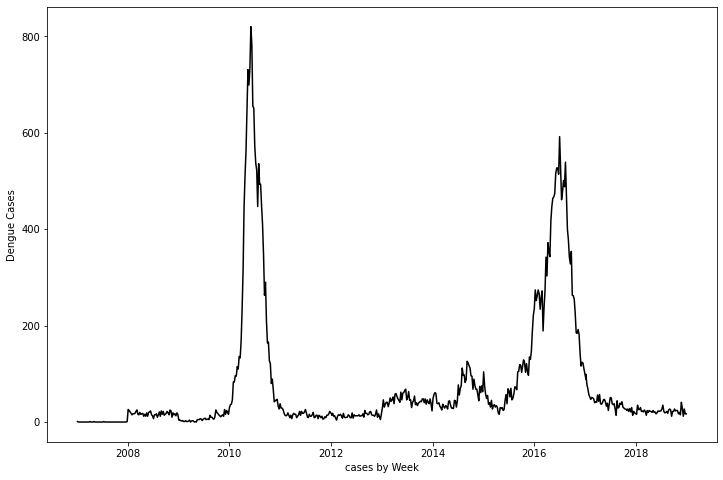

In [268]:
# Dengue cases in time
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (12, 8))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label) 
    plt.ylabel('Dengue Cases')

timeseries(merge_cases_temp_precip['LastDayWeek'], merge_cases_temp_precip['cases_medellin'], 'cases by Week')

## DataSet

In [269]:
dataset = merge_cases_temp_precip[['temperature_medellin','percipitation_medellin','cases_medellin']]
dataset.index = merge_cases_temp_precip.LastDayWeek
dataset  #DF

,temperature_medellin,percipitation_medellin,cases_medellin
LastDayWeek,,,
2007-01-06,21.009283,13.096688,1
2007-01-13,21.009283,8.437044,0
2007-01-20,21.009283,19.373165,0
2007-01-27,21.009283,0.000000,0
2007-02-03,20.982925,3.725206,0
...,...,...,...
2018-12-01,20.936353,8.916642,28
2018-12-08,20.936353,17.006086,12
2018-12-15,20.936353,5.673248,27


# Prepare data to supervised learning time series

we will use:
* data: is the dataframe in our case (Dengue Cases, Precipitation and Temperature)
* n_in: is the number of lag weeks in the past (length of window)

The heart of this "series_to_supervised" function is the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html">shift</a> fuction of pandas

This function gets as input the number of periods(in this case the number of weeks represented as rows up or down in the dataframe) to move the columns of a dataframe.
E.g. 
* If we have merge_cases_temp_precip['cases_medellin'].shift(1) all the rows of column cases_medellin will move one row down
* If we have merge_cases_temp_precip['cases_medellin'].shift(-1) all the rows of column cases_medellin will move one row up


In [270]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

### normalize features
As we are working with a Neural Network the data values ​​must be normalized to help backpropagation algorithm
So we will use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a> from sklearn

In [271]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Scaler between 0 and 1
scaled = scaler.fit_transform(dataset) # As we can see data set has 3 Columns (This shape is also important for inverse scaler as we will see in future)

In [272]:
# length of window
weeks = 2

# frame as supervised learning
data = series_to_supervised(scaled, n_in=weeks)
DataFrame(data).head()

,var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
2,0.364241,0.103033,0.00122,0.364241,0.066375,0.0,0.364241,0.152411,0.0
3,0.364241,0.066375,0.00000,0.364241,0.152411,0.0,0.364241,0.000000,0.0
4,0.364241,0.152411,0.00000,0.364241,0.000000,0.0,0.356053,0.029307,0.0
5,0.364241,0.000000,0.00000,0.356053,0.029307,0.0,0.356053,0.095100,0.0
6,0.356053,0.029307,0.00000,0.356053,0.095100,0.0,0.356053,0.011560,0.0


## Features Set

In [273]:
# We define the number of features as 3 (Temperature, Precipitation and Dengue Cases)
n_features = 3
# The features to train the model will be all except the values of the actual week 
# We can't use the temperature and precipitation in week t because whe need to resample a a 3D Array
features_set = DataFrame(data.values[:,:-n_features])
# Convert pandas data frame to np.array to reshape as 3D Array
features_set = features_set.to_numpy()
features_set

array([[0.36424094, 0.10303316, 0.00121951, 0.36424094, 0.0663752 ,
        0.        ],
       [0.36424094, 0.0663752 , 0.        , 0.36424094, 0.15241093,
        0.        ],
       [0.36424094, 0.15241093, 0.        , 0.36424094, 0.        ,
        0.        ],
       ...,
       [0.34158643, 0.07014825, 0.03414634, 0.34158643, 0.13378884,
        0.01463415],
       [0.34158643, 0.13378884, 0.01463415, 0.34158643, 0.0446321 ,
        0.03292683],
       [0.34158643, 0.0446321 , 0.03292683, 0.34158643, 0.02191073,
        0.02073171]])

## Labels Set

In [274]:
# We will use Dengue cases in last week 
labels_set = DataFrame(data.values[:,-1])
# Convert pandas data frame to np.array
labels_set = labels_set.to_numpy()
labels_set

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00121951],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

## Train Test Split

In [275]:
# We need a sequence so we can't split randomly
# To divide into Train (90%) and test (10%) to do that we need to know the 90% of the total dataframe
size = features_set.shape[0]
split = int(size*(9/10))

### train

In [276]:
# We will train with 1st 90% of data and test with last 10%
train_X = features_set[:split] ##90% train
train_y = labels_set[:split]  ##90% train

### test

In [277]:
test_X = features_set[split:] ##10% test
test_y = labels_set[split:] ##10% test

## Reshape

In [278]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], weeks, n_features))
test_X = test_X.reshape((test_X.shape[0], weeks, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(559, 2, 3) (559, 1) (63, 2, 3) (63, 1)


## Model

### LSTM

In [279]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [280]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
8/8 - 3s - loss: 0.0836 - val_loss: 0.0107
Epoch 2/50
8/8 - 0s - loss: 0.0753 - val_loss: 0.0218
Epoch 3/50
8/8 - 0s - loss: 0.0750 - val_loss: 0.0118
Epoch 4/50
8/8 - 0s - loss: 0.0703 - val_loss: 0.0075
Epoch 5/50
8/8 - 0s - loss: 0.0653 - val_loss: 0.0101
Epoch 6/50
8/8 - 0s - loss: 0.0625 - val_loss: 0.0115
Epoch 7/50
8/8 - 0s - loss: 0.0597 - val_loss: 0.0094
Epoch 8/50
8/8 - 0s - loss: 0.0559 - val_loss: 0.0093
Epoch 9/50
8/8 - 0s - loss: 0.0520 - val_loss: 0.0099
Epoch 10/50
8/8 - 0s - loss: 0.0483 - val_loss: 0.0088
Epoch 11/50
8/8 - 0s - loss: 0.0438 - val_loss: 0.0085
Epoch 12/50
8/8 - 0s - loss: 0.0390 - val_loss: 0.0082
Epoch 13/50
8/8 - 0s - loss: 0.0338 - val_loss: 0.0077
Epoch 14/50
8/8 - 0s - loss: 0.0282 - val_loss: 0.0070
Epoch 15/50
8/8 - 0s - loss: 0.0228 - val_loss: 0.0064
Epoch 16/50
8/8 - 0s - loss: 0.0186 - val_loss: 0.0055
Epoch 17/50
8/8 - 0s - loss: 0.0164 - val_loss: 0.0051
Epoch 18/50
8/8 - 0s - loss: 0.0158 - val_loss: 0.0050
Epoch 19/50
8/8 - 0

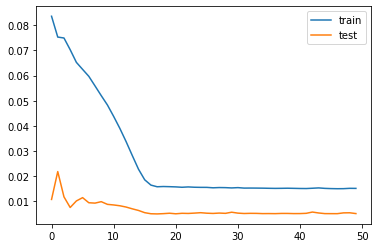

In [281]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [282]:
from math import sqrt
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X)

In [283]:
yhat.shape

(63, 1)

In [284]:
# Convert test data to 2D 
test_X = test_X.reshape((test_X.shape[0], weeks*n_features))

# invert scaling for forecast
# As we said Scaler needs 3 columns so we can take those columns from test data and take again the predictions
# Concatenate last 2 columns of test data with predicted data (yhat)
inv_yhat = concatenate((test_X[:, -(n_features-1):], yhat), axis=1)
# Inverse Scaler
inv_yhat = scaler.inverse_transform(inv_yhat)
# Take predicted data scaled to original Dengue cases
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
# Same process than for predicted data (yhat)
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -(n_features-1):], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [285]:
from sklearn.metrics import  mean_absolute_error

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 4.198


#### Plot predicted vs actual dengue cases

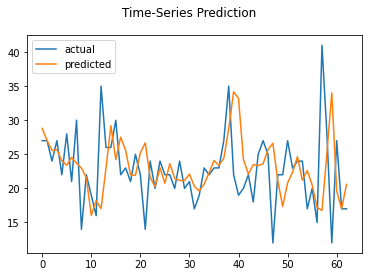

In [286]:
data_predict = inv_yhat  ## predicted target  cases
dataY_plot = inv_y  ##  real test-target cases

data_predict = data_predict.reshape(len(data_predict), 1)
dataY_plot = dataY_plot.reshape(len(dataY_plot), 1)

import matplotlib.pyplot as plt

plt.plot(dataY_plot, label = 'actual')
plt.plot(data_predict, label = 'predicted')
plt.legend(loc="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

### GRU

In [287]:
# design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [288]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], weeks, n_features))
test_X = test_X.reshape((test_X.shape[0], weeks, n_features))

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
8/8 - 2s - loss: 0.0965 - val_loss: 0.0540
Epoch 2/50
8/8 - 0s - loss: 0.1048 - val_loss: 0.0466
Epoch 3/50
8/8 - 0s - loss: 0.0925 - val_loss: 0.0074
Epoch 4/50
8/8 - 0s - loss: 0.0779 - val_loss: 0.0066
Epoch 5/50
8/8 - 0s - loss: 0.0674 - val_loss: 0.0152
Epoch 6/50
8/8 - 0s - loss: 0.0649 - val_loss: 0.0108
Epoch 7/50
8/8 - 0s - loss: 0.0594 - val_loss: 0.0110
Epoch 8/50
8/8 - 0s - loss: 0.0546 - val_loss: 0.0123
Epoch 9/50
8/8 - 0s - loss: 0.0507 - val_loss: 0.0096
Epoch 10/50
8/8 - 0s - loss: 0.0455 - val_loss: 0.0091
Epoch 11/50
8/8 - 0s - loss: 0.0407 - val_loss: 0.0080
Epoch 12/50
8/8 - 0s - loss: 0.0352 - val_loss: 0.0084
Epoch 13/50
8/8 - 0s - loss: 0.0301 - val_loss: 0.0070
Epoch 14/50
8/8 - 0s - loss: 0.0244 - val_loss: 0.0070
Epoch 15/50
8/8 - 0s - loss: 0.0200 - val_loss: 0.0061
Epoch 16/50
8/8 - 0s - loss: 0.0170 - val_loss: 0.0053
Epoch 17/50
8/8 - 0s - loss: 0.0157 - val_loss: 0.0052
Epoch 18/50
8/8 - 0s - loss: 0.0156 - val_loss: 0.0064
Epoch 19/50
8/8 - 0

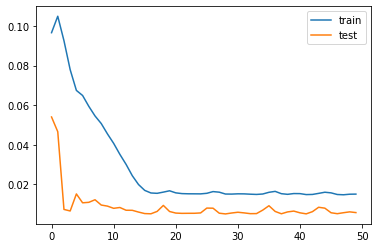

In [289]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [290]:
from math import sqrt
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X) 
test_X = test_X.reshape((test_X.shape[0], weeks*n_features))

In [291]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -(n_features-1):], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -(n_features-1):], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [292]:
from sklearn.metrics import  mean_absolute_error

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 4.784


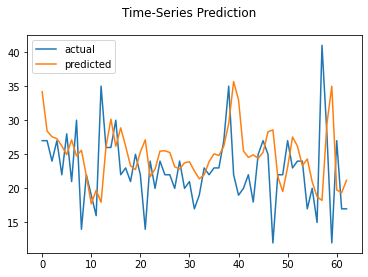

In [293]:
data_predict = inv_yhat  ## predicted target  cases
dataY_plot = inv_y  ##  real test-target cases

data_predict = data_predict.reshape(len(data_predict), 1)
dataY_plot = dataY_plot.reshape(len(dataY_plot), 1)

import matplotlib.pyplot as plt

plt.plot(dataY_plot, label = 'actual')
plt.plot(data_predict, label = 'predicted')
plt.legend(loc="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

<ol>
  <li> <a href="https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915">Predictive Analytics: Time-Series Forecasting with GRU and BiLSTM in TensorFlow</a></li>
  <li><a href="https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/">Multivariate Time Series Forecasting with LSTMs in Keras</a></li>
</ol>